## Question 1

In [1166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

Consider shuttle dispatching problem in which a dispatcher is responsible to decide whether or not
to dispatch a shuttle at each decision epoch depending on number of customers waiting for the service. A
standard shuttle dispatch problem has following parameters:

- K = The capacity of a shuttle if it is dispatched.
- At = A random variable giving the number of customers arriving during time interval t.
- cf = The cost of dispatching a shuttle.
- ch = The cost per customer left waiting per time period.

Given K = 15, cf = 100, ch = 2 and assuming that At follows unif{1,5}...

In [578]:
max_time = 500
K = 201 # platform capacity
cf = -100 # cost of dispatching a shuttle
ch = -2 # cost per customer left waiting per time period
cap = 15 # shuttle capacity
gamma = 0.95

### Enumeration

In [194]:
Vt = np.repeat(0.0,K)
Vt_future = np.repeat(0.0,K)
for time in range(max_time, -1, -1): # timeframe
    for st in range(K): # every state
        Vt_shut = cf + (ch * max(st-cap, 0))
        Vt_no_shut = ch * st
        for new in range(1, 6): # number of new customers
            Vt_shut = Vt_shut + (.2 * gamma * Vt_future[max(st+new-cap, 0)]) # make sure doesn't go below zero
            Vt_no_shut = Vt_no_shut + (.2 * gamma * Vt_future[min(st+new, K-1)]) # can't go over 200
        Vt[st] = max(Vt_shut, Vt_no_shut)
    Vt_future = Vt

Text(0,0.5,'Value')

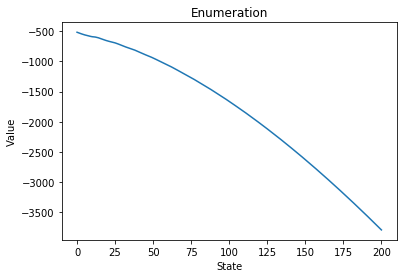

In [195]:
plt.plot(range(0,201), Vt)
plt.title("Enumeration")
plt.xlabel("State")
plt.ylabel("Value")

### Value Iteration

In [206]:
# initialization
theta = 10e-6
Vt = np.repeat(0.0,K)
Vt_next = np.repeat(0.0,K)

# policy evaluation
while True: 
    Vt_next = Vt.copy()
    delta = 0
    for st in range(K): # every state
        Vt_shut = cf + (ch * max(st-cap, 0))
        Vt_no_shut = ch * st
        for new in range(1, 6): # number of new customers
            Vt_shut = Vt_shut + (.2 * gamma * Vt_next[max(st+new-cap, 0)])
            Vt_no_shut = Vt_no_shut + (.2 * gamma * Vt_next[min(st+new, K-1)])
        Vt[st] = max(Vt_shut, Vt_no_shut)
    delta = max(delta, max(abs(Vt_next-Vt)))
    if(delta < theta):
        break

Text(0,0.5,'Value')

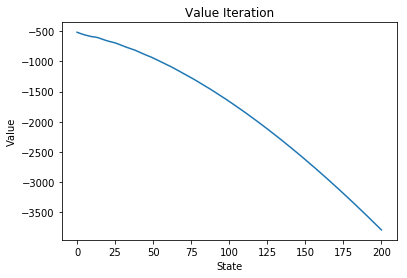

In [207]:
plt.plot(range(0,201), Vt)
plt.title("Value Iteration")
plt.xlabel("State")
plt.ylabel("Value")

### Policy Iteration 

In [686]:
# initialization
Vt = np.repeat(0.0,K)
Vt_next = np.repeat(0.0,K)
policy = np.random.randint(2,size=K) # 0 = no shuttle, 1 = shuttle
policy_new = np.random.randint(2,size=K)
theta = 10e-6
delta = 2

changed = True
while changed: 
    # policy evaluation
    while theta < delta:
        delta = 0
        Vt_next = Vt.copy()
        for st in range(K):
            v = Vt[st] # old value
            Vt_shut = cf + (ch * max(st-cap, 0))
            Vt_no_shut = ch * st
            for new in range(1, 6): # number of new customers
                Vt_shut = Vt_shut + (.2 * gamma * Vt_next[max(st+new-cap, 0)])
                Vt_no_shut = Vt_no_shut + (.2 * gamma * Vt_next[min(st+new, K-1)])
            values = [Vt_no_shut, Vt_shut]
            Vt[st] = values[policy[st]]
            delta = max(delta, abs(v-Vt[st]))
            
    # policy improvement
    for st in range(K):
        Vt_shut = cf + (ch * max(st-cap, 0))
        Vt_no_shut = ch * st
        for new in range(1, 6): # number of new customers
            Vt_shut = Vt_shut + (.2 * gamma * Vt_next[max(st+new-cap, 0)])
            Vt_no_shut = Vt_no_shut + (.2 * gamma * Vt_next[min(st+new, K-1)])
        values = [Vt_no_shut, Vt_shut]
        policy_new[st] = np.argmax(values)
     
    # check if policy is stable
    if not all(policy_new == policy):
        delta = 2
        policy = policy_new.copy()
    else:
        changed = False

Text(0,0.5,'Value')

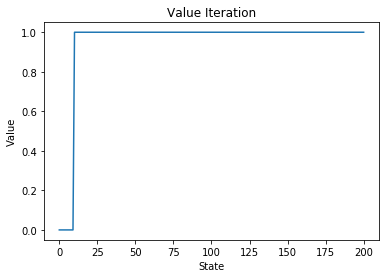

In [688]:
plt.plot(range(0,201), policy)
plt.title("Value Iteration")
plt.xlabel("State")
plt.ylabel("Value")

## Question 2

Now consider the multiclass problem in which we have different types of customers. Assume that there
are 5 types of customers with ch = {1, 1.5, 2, 2.5, 3} and each type can have maximum 100 people of each
class waiting for shuttle and At for each class follows same distribution. Capacity of the shuttle is K = 30.
Try to repeat a), b) and c) from problem 1.

### Enumeration

In [1153]:
max_time = 500

K = 4 # platform capacity per class
ch = [-1, -1.5, -2, -2.5, -3]  # cost per customer left waiting per time period
cf = -100 # cost of dispatching a shuttle

cap = 30 # shuttle capacity
gamma = 0.95

In [1154]:
def load_shuttle(current_state, cap):
    # let the highest class customers get on the shuttle first
    result = current_state.copy()
    for i in range(4, -1, -1):
        result[i] = max(current_state[i]-cap, 0)
        cap = cap - abs(current_state[i]-result[i])
    return(result)

In [1155]:
def get_reward(states, ch, cf, cap):
    # value of no shuttle
    Vt_no_shut = sum(np.multiply(states, ch))
    
    # let the highest class customers get on the shuttle first
    future_state = load_shuttle(states, cap)
    Vt_shut = cf + sum(np.multiply(future_state, ch))
    
    # return reward
    return(Vt_no_shut, Vt_shut)

In [1156]:
def get_expected_future(state, arrivals, Vt_future, gamma, K, cap):
    # make all the iterations of new people arriving
    new_people = []
    for people in arrivals: 
        new_people.append(np.add(people,state))
    new_people = np.clip(new_people, 0, K-1)
    
    # expected future of no shuttle
    no_shut = 0
    for group in new_people:
        no_shut = no_shut + ((1/len(arrivals)) * gamma * Vt_future[tuple(group)])
        
    # expected future of shuttle
    shut = 0
    for group in new_people:
        new_group = load_shuttle(group, cap)
        shut = shut + ((1/len(arrivals)) * gamma * Vt_future[tuple(new_group)])
    return(no_shut, shut)

In [1157]:
# initializes empty value dictionaries
# the key for each value is the number of people of each class
Vt = {}
for st0 in range(K): # every state
    for st1 in range(K):
        for st2 in range(K):
            for st3 in range(K):
                for st4 in range(K):
                    Vt[(st0,st1,st2,st3,st4)] = 0
Vt_future = Vt.copy()

In [1158]:
# at any given time t, between 1 and 5 people of each class can arrive
# this iterates out all of them 
arrivals = []
for st0 in range(1, 6): # every state
    for st1 in range(1,6):
        for st2 in range(1,6):
            for st3 in range(1,6):
                for st4 in range(1,6):
                    arrivals.append([st0,st1,st2,st3,st4])

In [1159]:
t1 = time.time()
for time in range(max_time, -1, -1): # timeframe
    for st0 in range(K): # every state for ever class of customers
        for st1 in range(K):
            for st2 in range(K):
                for st3 in range(K):
                    for st4 in range(K):
                        rewards = get_reward([st0,st1,st2,st3,st4], ch, cf, cap)
                        future = get_expected_future([st0,st1,st2,st3,st4], arrivals, Vt_future, gamma, K, cap)
                        
                        no_shuttle = rewards[0] + future[0]
                        shuttle = rewards[1] + future[1]
                        Vt[tuple([st0,st1,st2,st3,st4])] = max(no_shuttle, shuttle)
    Vt_future = Vt.copy()
t2 = time.time()
print("Time elapsed (sec): ", t2-t1)

In [1165]:
for i in range(K):
    print(Vt[(i,0,0,0,0)])

-378.099999997
-379.289999997
-380.289999997


In [1164]:
Vt

{(0, 0, 0, 0, 0): -378.0999999972874,
 (0, 0, 0, 0, 1): -381.66999999729177,
 (0, 0, 0, 0, 2): -384.66999999729177,
 (0, 0, 0, 1, 0): -381.07499999728731,
 (0, 0, 0, 1, 1): -384.64499999729145,
 (0, 0, 0, 1, 2): -387.64499999729145,
 (0, 0, 0, 2, 0): -383.57499999728731,
 (0, 0, 0, 2, 1): -387.14499999729145,
 (0, 0, 0, 2, 2): -390.14499999729145,
 (0, 0, 1, 0, 0): -380.47999999728722,
 (0, 0, 1, 0, 1): -384.04999999729165,
 (0, 0, 1, 0, 2): -387.04999999729165,
 (0, 0, 1, 1, 0): -383.45499999728719,
 (0, 0, 1, 1, 1): -387.02499999729133,
 (0, 0, 1, 1, 2): -390.02499999729133,
 (0, 0, 1, 2, 0): -385.95499999728719,
 (0, 0, 1, 2, 1): -389.52499999729133,
 (0, 0, 1, 2, 2): -392.52499999729133,
 (0, 0, 2, 0, 0): -382.47999999728722,
 (0, 0, 2, 0, 1): -386.04999999729165,
 (0, 0, 2, 0, 2): -389.04999999729165,
 (0, 0, 2, 1, 0): -385.45499999728719,
 (0, 0, 2, 1, 1): -389.02499999729133,
 (0, 0, 2, 1, 2): -392.02499999729133,
 (0, 0, 2, 2, 0): -387.95499999728719,
 (0, 0, 2, 2, 1): -391.524

In [1167]:
t1 = time.time()

In [1168]:
t2 = time.time()

In [1169]:
t2-t1

9.367748022079468